In [1]:
import cv2
import google.colab.patches as colab
import matplotlib.pyplot as plt
import numpy

#**Non-Uniform Pattern Handling**

##**Uniform Checking**

**isUniform()**
:check if the 256-level LBP code is uniform or not

* input: (1) a bit sequence (2) max_transition
* output: True (uniform) / False (non-uniform)


In [2]:
def isUniform(bit_seq, max_transition):
  # init transition as zero and mask as 0b1000 0000
  transition = 0
  mask = 0x80

  # compare 7 bit pairs from the most significant bit
  for i in range(7):
    # get the bit pair by bitwise AND operator
    bit_1 = bit_seq & mask
    bit_seq = bit_seq << 1
    bit_2 = bit_seq & mask

    # increase transition is bit1 != bit2
    if bit_1 != bit_2:
      transition = transition + 1

  # deal with non-uniform
  if transition > max_transition:
    return False

  return True

##**Map Construction** 
* 58 uniform: assign each with an unique index (0-57)
* 198 non-uniform: assign all with 58

**constructMapTable()**: map 256-level LBP to 59-level one

* input: none
* output: LBP Map Table

In [3]:
def constructMapTable():
  # create map
  map = numpy.zeros(256, dtype=numpy.int32)

  # init level index and number of maximum transitions
  index_59L = 0
  max_transition = 2

  # go through all 256 LBP levels
  for level in range(256):
    if isUniform(level, max_transition):
      map[level] = index_59L
      index_59L = index_59L + 1
    else:
      map[level] = 58 
  
  return map

#**Binary Encoding**

##**256-Level Encoding**

**encode()**: encode each point as a 256-level LBP

* input: (1) image mat (2) point position (row,col)
* output: 256-Level LBP code

In [4]:
def encode(mat, pos):
  # define the offsets of 8 neighbor points
  neighbor_offset = numpy.array([[0, 1], [-1, 1], [-1, 0], [-1, -1],
                   [0, -1], [1, -1], [1, 0], [1, 1]])
  
  # calculate the neighbor positions
  neighbor_pos = pos + neighbor_offset

  # get the center intensity
  g = mat[pos[0], pos[1]]

  # threshold neighbor intensity by g
  code_256L = 0

  for i in range(len(neighbor_pos)):
    # shift one-bit right
    code_256L = code_256L >> 1

    # get the intensity of ith neighbor point
    g_i = mat[neighbor_pos[i,0], neighbor_pos[i,1]]

    # binarization
    if g_i >= g:
      code_256L = code_256L | 0x80
        
  return code_256L

##**gather statistics of LBP occurrence**

load the image from file

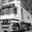

In [5]:
in_mat = cv2.imread("/content/drive/MyDrive/Colab Notebooks/LBP_local binary pattern/cifar10.bmp", 0)
colab.cv2_imshow(in_mat)

construct the map table for mapping 256-level to 59-level LBP



In [6]:
map = constructMapTable()

create the LBP histogram as zero

In [7]:
LBP_hist = numpy.zeros(59, dtype=numpy.float32)

encode every points to 58-Level LBP histogram

In [8]:
# skip the boundary points
for row in range(1,in_mat.shape[0]-1):
  for col in range(1, in_mat.shape[1]-1):
    # encode the point at (row, col) to 256-Level LBP
    code_256L = encode(in_mat, [row, col])

    # map to 59-level LBP
    code_59L = map[code_256L]

    # accumulate the LBP histogram
    LBP_hist[code_59L] = LBP_hist[code_59L] + 1
    
# normalize the LBP histogram
Z = LBP_hist.sum()
LBP_hist = LBP_hist / Z

display the LBP histogram

<BarContainer object of 59 artists>

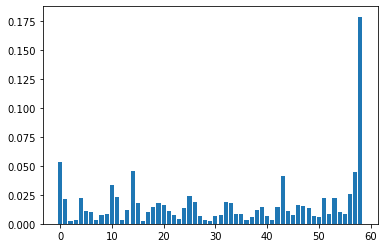

In [9]:
plt.bar(range(LBP_hist.shape[0]), LBP_hist)